<a href="https://colab.research.google.com/github/gabrielxcosta/Simulation-of-epidemiological-models-in-temporal-mobility-networks/blob/main/Semana%207/Comparing_metapopulation_dynamics_of_infectious_diseases_under_different_models_of_human_movement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

# Travel Destination Choice Model

</center>

In [ ]:
library(data.table)
library(ggplot2)
library(MASS)
library(tidyverse, quietly = TRUE)
library(nnet)

install.packages('rgdal')
library(rgdal)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘sp’


Loading required package: sp

Please note that rgdal will be retired during 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.
See https://r-spatial.org/r/2022/04/12/evolution.html and https://github.com/r-spatial/evolution
rgdal: version: 1.6-6, (SVN revision 1201)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.3.2, released 2021/09/01
Path to GDAL shared files: /usr/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 7.2.1, January 1st, 2021, [PJ_VERSION: 721]
Path to PROJ shared files: /root/.local/share/proj:/usr/share/proj
PROJ CDN enabled: FALSE
Linking to sp version:1.6-0
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading sp or rgdal.



# Introduction
This document shows how the multinomial destination choice model was developed for the analysis presented in the article "Comparing Metapopulation Dynamics of Infectious Diseases under Different Models of Human Movement" by Citron et al. 

We will use data from the 2015-2017 BIMEP malaria indicator surveys which record how many people reported going from their homes to each of seven destination regions. We will use these data, along with population, distance, and location covariates to fit a multinomial probability model of destination choice. The results appear as the columns `p_mainland`, `p_baney`, etc in Comparing_Metapopulation_Dynamics_companion_code.Rmd.

# Load data
The columns in this data set are as follows:

  * area_index: Unique label for each map area
  * lon/lat: Longitude and latitude for each map area
  * region: Region where each map area is located. The map areas Malabo region have been categorized as either in urban Malabo ("Malabo") or in the periurban areas around the city ("Periurban"). The other map area regions are Baney, Luba, Moka, Riaba, and Ureka.
  * population: Number of residents for each map area
  * sample_size: Number of people sampled from each map area in each MIS
  * t_eg, ti_ban, etc: Reported numbers trips to mainland Equatorial Guinea (eg); Baney (ban); Luba (lub), Malabo (mal), Moka (mok), Riaba (ria), and Ureka (ure)
  * dist_eg, dist_ban, etc: Distance to each destination region. This is computed as the distance to the centroids of each of the destination regions, calculated from the lon/lat coordinates.
  * year: Year of the study

In [ ]:
mul_model_data <- fread("Dataset_S1_raw_survey_data.csv")

We will fit a multinomial model of destination choice to the data. We first have to transform the data to apply the `nnet::multinom`. We have to create a second data set to also perform the prediction. Much of the operations below have to do with that. The results appear as the columns `p_mainland`, `p_baney`, etc in Comparing Metapopulation Dynamics Companion Code.

In [ ]:
# Create a dummy table, which says how many trips were reported to each destination region
dummy_1 <- melt(mul_model_data,
                 id.vars = c("area_index", "population", "year", "region", 
                             "dist_eg", "dist_ban", "dist_lub", 
                             "dist_mal", "dist_mok", "dist_ria", "dist_ure"),
                 measure.vars = list(c("t_eg", "ti_ban", "ti_lub", "ti_mal", 
                                       "ti_mok", "ti_ria", "ti_ure")),
                 value.name = c("counts"),
                 variable.name = "dest_reg")

# Create another dummy table, with the populations of the destination regions
dummy_2 <- data.table(
        dest_reg = c("t_eg", "ti_ban", "ti_lub", "ti_mal",  "ti_ria", "ti_mok", "ti_ure"),
        dest_pop = c(1071785, # this is the off-island population of equatorial guinea
          round(sum(mul_model_data[region == "Baney"]$pop)/4), 
          round(sum(mul_model_data[region == "Luba"]$pop)/4),
          round(sum(mul_model_data[region %in% c("Malabo", "Peri")]$pop)/4),
          round(sum(mul_model_data[region == "Moka"]$pop)/4),
          round(sum(mul_model_data[region == "Riaba"]$pop)/4),
          round(sum(mul_model_data[region == "Ureka"]$pop)/4)
          )  
        )
dummy_1 <- merge(dummy_1, dummy_2, by = "dest_reg")

# Create dummy variable for location
dummy_3 <- dcast(mul_model_data, area_index ~ region, 
                 fun.aggregate = function(region){return(as.numeric(length(region)>0))}, 
                 value.var = "region")

# Merge the two tables to create a new table which we will use 
# to retrieve model predictions later
multinom_data_predict <- merge(dummy_1, dummy_3, by = "area_index")

# To perform the model fit, we explode out the rows of multinom_data_predict
# such that each row corresponds to one reported trip to one destination
multinom_data_fit <- multinom_data_predict[counts > 0]
multinom_data_fit <- multinom_data_fit[rep(seq(1, nrow(multinom_data_fit)),
                                           multinom_data_fit$counts)]                                          

Perform the model fit using `nnet::multinom`. We fit the probability of choosing a destination (dest_reg) vs. the region of origin, population at the area of origin, and distance to each of the destination regions.

In [ ]:
mul_model <- nnet::multinom(
  dest_reg ~ population + 
  # distance covariates
  dist_eg + dist_ban + dist_lub + dist_mal + 
  dist_mok + dist_ria + dist_ure + 
  # indicator variables for region of origin
  Baney + Luba + Malabo + Moka + Periurban + Riaba + Ureka, 
  data = multinom_data_fit, 
  maxit = 1000)

# Extract Predictions
mul_predict <- predict(mul_model,
                       # newdata = holder.1[ix == "to"],
                       multinom_data_predict[dest_reg == "t_eg"],
                       type = "probs") # note that everything row does sum to 1
mul_predict <- as.data.table(mul_predict)
mul_predict$area_index <- multinom_data_predict[dest_reg == "t_eg"]$area_index
mul_predict$year <- multinom_data_predict[dest_reg == "t_eg"]$year

# weights:  119 (96 variable)
initial  value 26513.025781 
iter  10 value 16252.649552
iter  20 value 16041.050652
iter  30 value 15937.032097
iter  40 value 15931.075405
iter  50 value 15874.221736
iter  60 value 14006.074663
iter  70 value 13811.233647
iter  80 value 13794.207382
iter  90 value 13792.413694
iter 100 value 13791.915933
iter 110 value 13791.698868
iter 120 value 13791.124262
iter 130 value 13791.046509
iter 130 value 13791.046424
iter 130 value 13791.046423
final  value 13791.046423 
converged


The table of destination probability distributions that is used in the accompanying documents and manuscript is the one from 2015 (and 2016 and 2017, they should be the same).

In [ ]:
head(mul_predict[year == 2015,
                 .(area_index, 
                   p_mainland = t_eg, p_baney = ti_ban, p_luba = ti_lub,
                   p_malabo = ti_mal, p_moka = ti_mok, p_riaba = ti_ria, 
                   p_ureka = ti_ure, year)])

area_index,p_mainland,p_baney,p_luba,p_malabo,p_moka,p_riaba,p_ureka,year
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.7029871,0.03472116,0.04512460,0.1966916,0.007091542,0.01288686,0.0004971597,2015
2,0.7072490,0.03201003,0.04363486,0.1963133,0.006895150,0.01325220,0.0006454555,2015
3,0.6405642,0.05477593,0.05688059,0.2259951,0.008027762,0.01351653,0.0002399052,2015
4,0.6803539,0.04159585,0.04983134,0.2067952,0.008059582,0.01302329,0.0003408320,2015
5,0.7057084,0.03309125,0.04486141,0.1949303,0.007826077,0.01308460,0.0004979219,2015
6,0.7105387,0.03003484,0.04285328,0.1950149,0.007610806,0.01328090,0.0006665353,2015


<center>

# Comparing Metapopulation Dynamics Companion Code

</center>

Welcome to the companion code supporting data and modeling for the article "Comparing Metapopulation Dynamics of Infectious Diseases under Different Models of Human Movement" by Citron et al. 

In this document, you will find the code for reproducing the analysis presented in the Malaria Modeling Example in the Results section of the main text. This includes the data and analysis presented in Figures 3 and 4.

The travel destination choice model, which is described in the supplement is contained in a separate document (Travel_Destination_Choice_Model.Rmd).

# Bioko Island Mapping and Travel Data
Here's the data set which we use to create the maps of PfPR and travel prevalence (Figure 4 A and B).

The columns are interpreted as follows:

  * area_index: unique label for each map area
  * lon/lat: longitude and latitude for each map area
  * destination_region: destination region where the map area is located
  * population: number of residents for each map area
  * PR: mean malaria prevalence (parasite rate)
  * P_travel: travel prevalence, probability of having left home in last 8 weeks. This is represented as $\pi_i$ in Supplementary Information Equation 1.
  * p_mainland, p_baney, etc: Multinomial probability distribution of choosing to go to each of seven destination locations included in the malaria indicator survey (Mainland Equatorial Guinea, Baney, Luba, Malabo, Moka, Riaba, Ureka). These probabilities are represented as $P\left(i \rightarrow d | i\right)$ in Supplementary Information Equation 1.

In [ ]:
bioko.island.clean.data <- fread("Dataset_S2_modeled_PR_and_travel.csv")

# Travel Duration
We use data from the 2018 Bioko Island Malaria Elimination Program malaria indicator survey, where survey participants reported the number of nights they spent away from home. We use an exponential model of travel duration to infer the average number of nights spent away for trips reported on Bioko Island and off-island to mainland Equatorial Guinea.

In [ ]:
travel.duration <- fread("Dataset_S3_travel_duration_data.csv")

# Fit data using an exponential distribution model of travel time
# Use maximum likelihood to find mean duration of travel time on island
f <- optimize(f = function(l){
  sum(dexp(x = travel.duration[destination == "on_island"]$duration, 
           rate = l, log = TRUE))
}, interval = c(0,1), maximum = TRUE)
mean.duration.on.island <- 1/f$maximum
# mean.duration.on.island = 10.34 
# An average of 10.34 nights spent away when traveling on Bioko Island

# Use maximum likelihood to find mean duration of travel time on mainland, off-island
f <- optimize(f = function(l){
  sum(dexp(x = travel.duration[destination == "off_island"]$duration, 
           rate = l, log = TRUE))
}, interval = c(0,1), maximum = TRUE)
mean.duration.off.island <- 1/f$maximum
# mean.duration.on.island = 21.22
# An average of 21.22 nights spent away when traveling off-island to the mainland

# Time at Risk Matrix Calculation

Our next step is to disambiguate the travel destinations. We do this by weighting the probability of traveling to each map area within each destination region according to map area population. That is to say: we assume there is an equal probability of visiting each person within each destination region. These probabilities are represented as $P\left(i \rightarrow d | i\right)P\left(d \rightarrow j | i, d\right)$ in Supplementary Information Equation 1.

In [ ]:
# Matrix of probabilities by travel destination
p_id <- bioko.island.clean.data[, 
         .(p_mainland, p_baney, p_luba, p_malabo, p_moka, p_riaba, p_ureka)]

# Create matrix that maps each of the seven destination regions into the 195 map areas
# (Note that we have 194 map areas on the island, and use the 195th one to 
# represent off-island travel)
mat.weighted <- matrix(0, nrow = 7, ncol = 195)
# off-island travel
mat.weighted[1,195] <- 1
# baney
mat.weighted[2, bioko.island.clean.data[destination_region == "Baney"]$area_index] <- 
  bioko.island.clean.data[destination_region == "Baney"]$population/
  sum(bioko.island.clean.data[destination_region == "Baney"]$population)
# Luba
mat.weighted[3, bioko.island.clean.data[destination_region == "Luba"]$area_index] <- 
  bioko.island.clean.data[destination_region == "Luba"]$population/
  sum(bioko.island.clean.data[destination_region == "Luba"]$population)
# Malabo
mat.weighted[4, bioko.island.clean.data[destination_region == "Malabo"]$area_index] <- 
  bioko.island.clean.data[destination_region == "Malabo"]$population/
  sum(bioko.island.clean.data[destination_region == "Malabo"]$population)
# Moka
mat.weighted[5, bioko.island.clean.data[destination_region == "Moka"]$area_index] <- 
  bioko.island.clean.data[destination_region == "Moka"]$population/
  sum(bioko.island.clean.data[destination_region == "Moka"]$population)
# Riaba
mat.weighted[6, bioko.island.clean.data[destination_region == "Riaba"]$area_index] <- 
  bioko.island.clean.data[destination_region == "Riaba"]$population/
  sum(bioko.island.clean.data[destination_region == "Riaba"]$population)
# Ureka
mat.weighted[7, bioko.island.clean.data[destination_region == "Ureka"]$area_index] <- 
  bioko.island.clean.data[destination_region == "Ureka"]$population/
  sum(bioko.island.clean.data[destination_region == "Ureka"]$population)

# Disambiguate travel destination 
p_ij <- as.matrix(p_id) %*% mat.weighted
# Add a 195th row, to represent the mainland. 
# Note that we do not have any data for the travel behavior 
# for the people who live on the mainland. We are primarily 
# interested in the how travel among residents of Bioko Island 
# contribute to importations, so we omit their travel behavior for now.
p_ij <- rbind(p_ij, c(rep(0, 194), 1))

Now we perform the time at risk matrix calculation. We use the travel prevalence ($\pi_i$); the probability matrix calculated above (`p_ij`, or $P\left(i \rightarrow d | i\right)P\left(d \rightarrow j | i, d\right)$); and the inverse of the mean travel durations to obtain the rates of returning home ($\tau_{ij}$). Together, we can calculate the *time at risk matrix* $\phi_{i,j}$ as described in Equation 3.

This is saved as "Time_At_Risk_Matrix.csv" in long format

In [ ]:
# Rate at which people leave home
pi_i <- c(bioko.island.clean.data$P_travel/56, 0)

# Rate at which people return home from destination j
tau_ij = c(rep(1/mean.duration.on.island, 194), 1/mean.duration.off.island)

Time.at.risk.matrix <- diag(1, nrow = 195, ncol = 195)
for (i in 1:195){
  # Off-diagonal element
  Time.at.risk.matrix[i,] <-  pi_i[i]*p_ij[i,]/tau_ij/(1 + sum(pi_i[i]*p_ij[i,]/tau_ij))
  # On-diagonal element: (Time spent at home) = 1 - (time spent everywhere else)
  Time.at.risk.matrix[i,i] <- 1 + Time.at.risk.matrix[i,i] - sum(Time.at.risk.matrix[i,])
}

# $R_0$ Calculations

Starting with the Time at Risk Matrix, we now calculate $R_0$ for each of the two models.

In [ ]:
## If necessary, load in time at risk matrix:
# Time.at.risk.matrix <- fread("Dataset_S4_time_at_risk_matrix.csv")
# Time.at.risk.matrix <- dcast(Time.at.risk.matrix, 
#                              area_index_i ~ area_index_j, 
#                              value.var= "T_ij")[,2:196]

## PfPR
# We include PR = 0.43 as the prevalence on the mainland
pfpr_input <- c(bioko.island.clean.data$PR, .43)

## Population
# Set population on mainland, index 195, to Malabo's population
pop_input <- c(bioko.island.clean.data$population,
               sum(bioko.island.clean.data[destination_region == "Malabo"]$population))


## Ross-Macdonald Parameters
a = 0.3*0.9
b = 0.55
c = 0.15
r = 1./200 # rate at which people recover
p = 0.9 # fraction of surviving mosquitoes
g = 1 - p # fraction of dying mosquitoes
peip = p^11 # fraction of mosquitoes who survive incubation period

## Flux Model
We use the flux volume matrix (Equation 4) and the assumption that the populations represent the equilibrium to compute the flux parameters. Then we use Equation 14 from the main text to compute $R_{0, \text{Flux}}$.

In [ ]:
# Rate at which people leave home
pi_i <- c(bioko.island.clean.data$P_travel/56, 0)
# Rates of returning home
# These are identical for all i, so the index on this refers to the destination j
tau_ij = c(rep(1/mean.duration.on.island, 194), 1/mean.duration.off.island)

# Population at each location
pop_input <- c(bioko.island.clean.data$population,
               sum(bioko.island.clean.data[destination_region == "Malabo"]$population))

# Rate of leaving to each destination location j from home location i
phi_ij = matrix(0, nrow = 195, ncol = 195)
for (i in 1:195){
  phi_ij[i,] = p_ij[i,]*pi_i[i]
}

# Flux model parameters
f_ij = matrix(0, nrow = 195, ncol = 195)
for (i in 1:195){
  for (j in 1:195){
    f_ij[i,j] = phi_ij[i,j]*Time.at.risk.matrix[i,i] + 
      tau_ij[i]*Time.at.risk.matrix[j,i]*pop_input[j]/pop_input[i]
  }
  f_ij[i,i] = 0.0
}

# Now calculate the net flux of those infected moving between each location
pop_infected = pop_input * pfpr_input
net_flux_infected <- rep(0, 195)
for (i in 1:195){
  net_flux_infected[i] <- +sum(f_ij[i,])*pop_infected[i] - (t(f_ij) %*% pop_infected)[i]
  # - (infected people who are leaving) + (infected people who are entering)
}


# Calculate kappa, for the flux model; which only requires local pfpr measurements
kappa <- pfpr_input
# Borrowing notation from Ruktanonchai et al. (2016, Ref #17)
d.vec <- (b*c*kappa/(1 + a*c*kappa/g))
g.x.flux <- t((r*pfpr_input + net_flux_infected/pop_input)/(1 - (pfpr_input)))
# Calculate Vectorial Capacity by inverting the Time at Risk matrix
VC.flux <- g.x.flux/d.vec
# Calculate Time at Risk R0 from vectorial capacity
R0.flux <- VC.flux[1:195]*b*c/r

## Simple Trip Model
Refer to Equations 15 and 16 from the main text for how to compute $R_{0, \text{ST}}$.

In [ ]:
# Calculate Kappa, the force of infection from humans to mosquitoes, 
# using the Time at Risk matrix
kappa <- as.vector(pop_input*pfpr_input) %*% Time.at.risk.matrix / 
  (as.vector(pop_input) %*% Time.at.risk.matrix)
# Borrowing notation from Ruktanonchai et al. (2016, Ref #17)
d.vec <- (b*c*kappa/(1 + a*c*kappa/g))
d.x.mat <- matrix(0, nrow = 195, ncol = 195);
for (i in 1:195){
  d.x.mat[i,i] = d.vec[i]
}
g.x <- r*pfpr_input/(1 - pfpr_input)
# Calculate Vectorial Capacity by inverting the Time at Risk matrix
VC.tar <- MASS::ginv(Time.at.risk.matrix %*% d.x.mat) %*% as.vector(g.x)
# Calculate Time at Risk R0 from vectorial capacity
R0.tar <- VC.tar[1:195]*b*c/r

Compare, using histograms. (Cf. Figure 5C in the main text.)

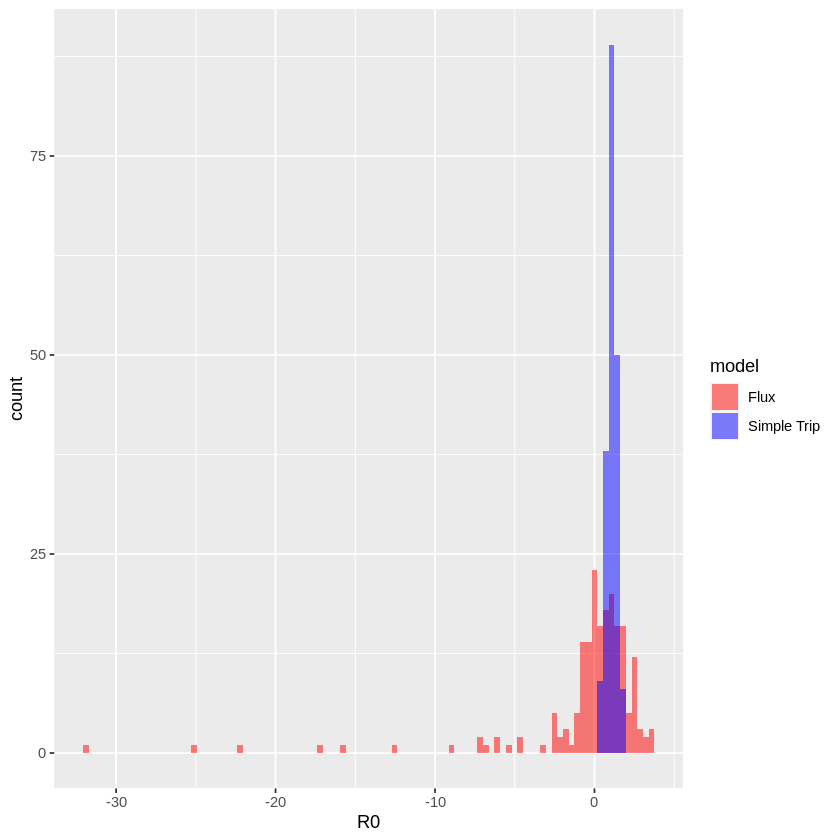

In [ ]:
hist.flux <- data.table(R0 = R0.flux[1:194], model = "Flux")
hist.st <- data.table(R0 = R0.tar[1:194], model = "ST")

r0.hist.data <- rbind(hist.st, hist.flux)

ggplot(data = r0.hist.data, aes(R0, fill = model)) +
  geom_histogram(alpha = 0.5, bins = 100, position = "identity") + 
  scale_fill_manual(name="model",values=c("red","blue"),labels=c("Flux","Simple Trip"))